In [ ]:
!mkdir -p /content/xBD/
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/test_images_labels_targets.tar' -C '/content/xBD/'
!tar -xvf '/content/drive/MyDrive/Colab_Notebooks/xBD/xView2_train_images.tar' -C '/content/xBD/'


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train/targets/hurricane-florence_00000096_post_disaster_target.png
train/targets/socal-fire_00001135_post_disaster_target.png
train/targets/hurricane-michael_00000244_pre_disaster_target.png
train/targets/hurricane-harvey_00000436_post_disaster_target.png
train/targets/mexico-earthquake_00000055_post_disaster_target.png
train/targets/socal-fire_00001125_post_disaster_target.png
train/targets/socal-fire_00001049_pre_disaster_target.png
train/targets/hurricane-harvey_00000156_pre_disaster_target.png
train/targets/hurricane-michael_00000500_pre_disaster_target.png
train/targets/hurricane-harvey_00000329_post_disaster_target.png
train/targets/hurricane-harvey_00000406_pre_disaster_target.png
train/targets/hurricane-florence_00000304_post_disaster_target.png
train/targets/guatemala-volcano_00000026_post_disaster_target.png
train/targets/socal-fire_00000423_post_disaster_target.png
train/targets/socal-fire_00000878_pre_disaster_target.png
train/targets/soc

# Train 데이터셋 분석 및 시각화

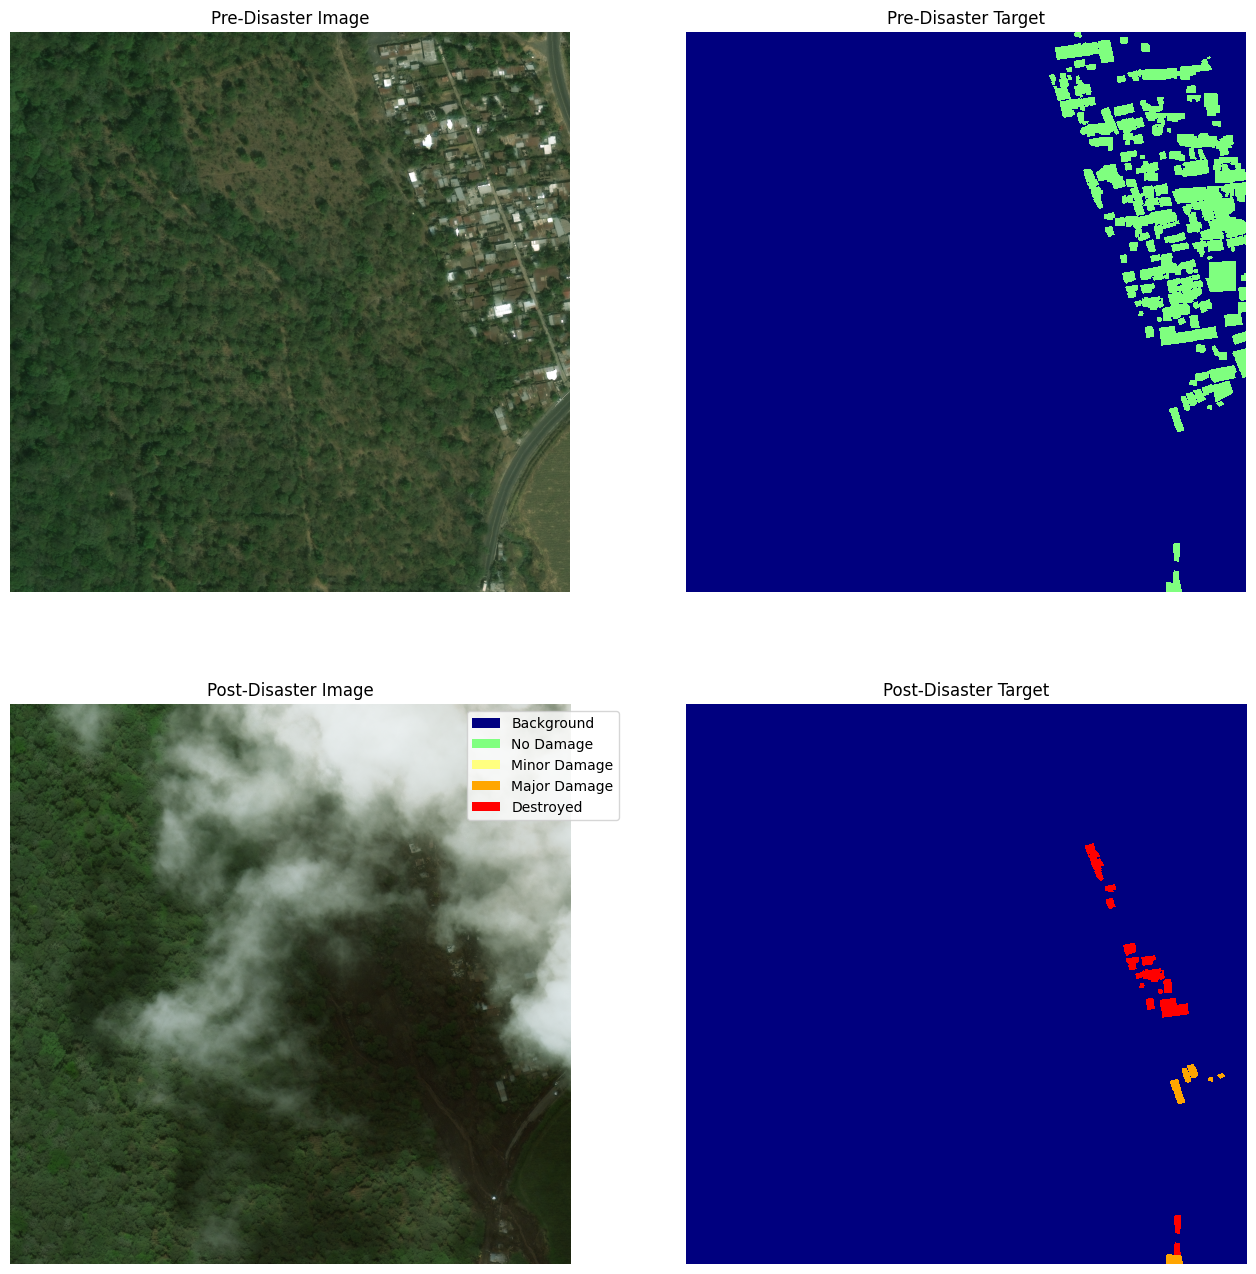

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# 이미지 파일 경로 설정
dir_path_pre = '/content/xBD/train/images/guatemala-volcano_00000025_pre_disaster.png'
dir_path_post = '/content/xBD/train/images/guatemala-volcano_00000025_post_disaster.png'
target_path_pre = '/content/xBD/train/targets/guatemala-volcano_00000025_pre_disaster_target.png'
target_path_post = '/content/xBD/train/targets/guatemala-volcano_00000025_post_disaster_target.png'

# 함수 정의: 이미지 로드 및 RGB 변환
def load_and_convert_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 로드
image_pre = load_and_convert_image(dir_path_pre)
image_post = load_and_convert_image(dir_path_post)

# 타겟 이미지 로드 및 시각화를 위한 컬러맵 설정
def load_and_prepare_target(target_path):
    image = Image.open(target_path)
    return np.array(image)

target_pre = load_and_prepare_target(target_path_pre)
target_post = load_and_prepare_target(target_path_post)

colors = [(0, 0, 0.5), (0.5, 1, 0.5), (1, 1, 0.5), (1, 0.65, 0), (1, 0, 0)]

# 레전드 정보 설정
legend_labels = ['Background', 'No Damage', 'Minor Damage', 'Major Damage', 'Destroyed']  # 레전드 레이블
legend_elements = [Patch(facecolor=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

cmap_name = 'custom1'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=5)

# 이미지 및 타겟 시각화
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# 원본 이미지 시각화
axs[0, 0].imshow(image_pre)
axs[0, 0].set_title('Pre-Disaster Image')
axs[0, 0].axis('off')

axs[1, 0].imshow(image_post)
axs[1, 0].set_title('Post-Disaster Image')
axs[1, 0].axis('off')

# 타겟 이미지 시각화
axs[0, 1].imshow(target_pre, cmap=cm, interpolation='nearest', vmin=0, vmax=4)
axs[0, 1].set_title('Pre-Disaster Target')
axs[0, 1].axis('off')

axs[1, 1].imshow(target_post, cmap=cm, interpolation='nearest', vmin=0, vmax=4)
axs[1, 1].set_title('Post-Disaster Target')
axs[1, 1].axis('off')

axs[1, 0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()

# 데이터셋 정의 및 전처리

In [ ]:
# 데이터셋 정의
class xBDataset(Dataset):
    def __init__(self, image_dir, target_dir, transform=None):
        self.image_dir = image_dir
        self.target_dir = target_dir
        self.transform = transform
        self.images = [img for img in os.listdir(image_dir) if 'post_disaster' in img]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 원본 이미지 파일 경로 생성
        img_path = os.path.join(self.image_dir, self.images[idx])
        # 타겟 이미지 파일 이름 수정
        target_file_name = self.images[idx].replace('.png', '_target.png')
        # 타겟 이미지 파일 경로 생성
        target_path = os.path.join(self.target_dir, target_file_name)

        image = Image.open(img_path).convert("RGB")
        target = Image.open(target_path)

        image = image.resize((256, 256))  # 이미지 크기를 256x256 픽셀로 조정
        target = target.resize((256, 256))

        target = np.array(target)  # Assuming target is a single-channel image

        if self.transform:
            image = self.transform(image)
            # 타겟 데이터를 PyTorch tensor로 변환합니다. 여기서는 long 타입이 필요합니다.
            target = torch.tensor(target, dtype=torch.long)

        return image, target

    def __len__(self):
        return len(self.images)


# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 훈련 이미지는 512x512로 조정
    transforms.RandomHorizontalFlip(),  # 무작위 수평 뒤집기
    transforms.RandomRotation(10),  # 무작위로 10도 내외로 회전
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
train_data = xBDataset(
    image_dir='/content/xBD/train/images',
    target_dir='/content/xBD/train/targets',
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [ ]:
# 모델 정의
class UNet(nn.Module):
    # U-Net 모델을 정의합니다. 이 부분은 간소화되었으며 실제로는 더 많은 레이어와 복잡성이 필요합니다.
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 추가된 레이어
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 추가된 레이어
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Encoder 부분은 여기서 더 많은 레이어를 추가할 수 있습니다.
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # 수정된 레이어
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # 추가된 레이어
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 추가된 레이어
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 추가된 레이어
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# 모델, 손실 함수, 최적화 함수 초기화

model = UNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 훈련 루프
num_epochs = 3
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정합니다.
    running_loss = 0.0

    for images, targets in train_loader:
        images = images.cuda()
        targets = targets.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# 모델 저장
torch.save(model.state_dict(), '/content/xBD/unet.pth')

Epoch [1/3], Loss: 0.0782
Epoch [2/3], Loss: 0.0653
Epoch [3/3], Loss: 0.0623


In [ ]:
from torchvision.utils import save_image

# 테스트 데이터셋 로드
test_dataset = xBDataset(
    image_dir='/content/xBD/test/images',  # 테스트 이미지 디렉토리
    target_dir='/content/xBD/test/targets',  # 테스트 타겟 디렉토리
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

result_dir = '/content/drive/MyDrive/Colab_Notebooks/xBD/test/predictions'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# # 첫 번째 배치의 이미지와 레이블 확인
# for images, labels in test_loader:
#     print("Images shape:", images.shape) # 이미지 배치의 형태
#     print("Labels:", labels) # 레이블 출력
#     break # 첫 번째 배치만 확인

# 모델 평가를 위한 함수
# 수정된 정확도 계산과 로깅
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_predictions = (predicted == labels).sum().item()
            correct += correct_predictions
            # 추가된 로깅
            print(f"Batch Correct: {correct_predictions}, Batch Total: {labels.size(0)}")
    accuracy = 100 * correct / total
    print('Test Accuracy of the model: {:.2f} %'.format(accuracy))

evaluate_model(model, test_loader)



# 모델을 평가 모드로 설정
model.eval()

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)


        # print(f"Batch {i} - Unique predicted classes: {torch.unique(predicted)}")

        # # 예측된 segmentation map 중 첫 번째를 예시로 확인
        # if i == 0:  # 첫 번째 배치만 확인합니다.
        #     first_pred = predicted[0]
        #     # 최대 값과 최소 값을 출력하여 전체 범위를 확인합니다.
        #     print(f"First prediction in batch - max: {first_pred.max()}, min: {first_pred.min()}")

        #     # 예시로 첫 번째 예측 segmentation map을 시각화합니다.
        #     plt.imshow(first_pred.cpu(), cmap='gray')
        #     plt.colorbar()
        #     plt.show()

        #     # 중단 조건, 필요에 따라 주석 처리할 수 있습니다.
        #     break  # 한 배치만 확인하고 중단합니다.


        for j in range(images.size(0)):
            # 원본 테스트 이미지의 파일명 가져오기
            image_filename = test_dataset.images[i * test_loader.batch_size + j]
            # 분할 결과 파일명 생성
            prediction_filename = image_filename.replace('.png', '_prediction.png')

            # 결과 이미지 저장 경로
            save_path = os.path.join(result_dir, prediction_filename)

            # 예측된 segmentation map을 정규화 및 저장
            normalized_prediction = predicted[j].cpu().float() / 4.0  # 클래스가 0부터 4까지 있다고 가정
            save_image(normalized_prediction, save_path)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
Batch Correct: 248522, Batch Total: 4
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..

KeyboardInterrupt: 

# Post_disaster 이미지 추론 결과 확인

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024)
Unique scaled predicted values: [0]
Unique scaled ground turth values: [0 1]


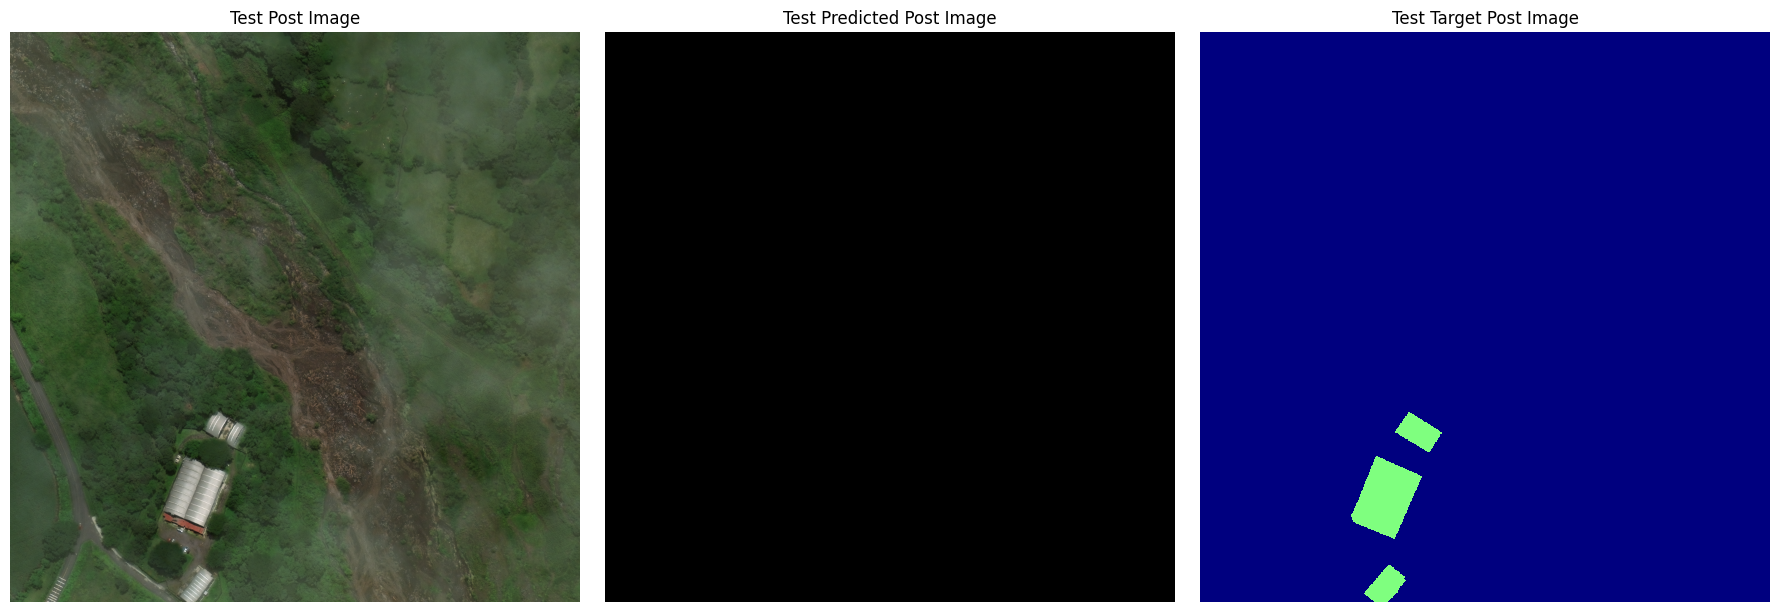

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.colors import ListedColormap

# 파일 위치 설정
test_post_image_path = '/content/xBD/test/images/guatemala-volcano_00000009_post_disaster.png'
test_predicted_post_path = '/content/drive/MyDrive/Colab_Notebooks/xBD/test/predictions/guatemala-volcano_00000009_post_disaster_prediction.png'
test_target_post_path = '/content/xBD/test/targets/guatemala-volcano_00000009_post_disaster_target.png'

# 이미지 로드 함수
def load_image(image_path, is_mask=False):
    image = Image.open(image_path)
    if is_mask:  # 타겟 이미지인 경우
        image = np.array(image)
        return image
    return np.array(image)

# 시각화를 위한 커스텀 컬러맵 생성
colors = [(0, 0, 0.5), (0.5, 1, 0.5), (1, 1, 0.5), (1, 0.65, 0), (1, 0, 0)]  # R, G, B
cmap = ListedColormap(colors)

# 이미지 로드
test_post_image = load_image(test_post_image_path)
test_predicted_post = load_image(test_predicted_post_path, is_mask=True)
test_target_post = load_image(test_target_post_path, is_mask=True)

# 예측된 이미지의 크기를 변경합니다.
test_predicted_post_resized = np.array(Image.fromarray(test_predicted_post).resize((1024, 1024)))

print(test_post_image.shape)
print(test_predicted_post_resized.shape)
print(test_target_post.shape)

unique_values_scaled = np.unique(test_predicted_post_resized)
print("Unique scaled predicted values:", unique_values_scaled)
unique_values_scaled = np.unique(test_target_post)
print("Unique scaled ground turth values:", unique_values_scaled)

# 이미지 시각화
plt.figure(figsize=(18, 6))

# 1행 1열: Test Post Image
plt.subplot(1, 3, 1)
plt.imshow(test_post_image, cmap='gray')
plt.title('Test Post Image')
plt.axis('off')

# 1행 2열: Test Predicted Post Image
plt.subplot(1, 3, 2)
plt.imshow(test_predicted_post_resized, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
plt.title('Test Predicted Post Image')
plt.axis('off')

# 1행 3열: Test Target Post Image
plt.subplot(1, 3, 3)
plt.imshow(test_target_post, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
plt.title('Test Target Post Image')
plt.axis('off')

plt.tight_layout()
plt.show()


#  정리

현재 주어진 데이터셋은 클래스가 총 5개가 있다. 하지만 정작 label을 보면 간혹 subtype에 5개 유형 외의 식별할 수 없는 유형이 지정 되어 있다.

unet에서 conv를 2개만 했을때는 배경 없음이라는 라벨이 건물과 손상 유형 라벨보다 압도적으로 많기 때문에 이미지 분할을 하더라도 클래스 0의 특징이 높아져서 나머지 라벨을 식별을 하기 힘들다. 물론 이코드는 에픽이 3이라는 적은 횟수로 실행했기 때문에 학습률이 낮아서 인식을 하지 못했다.

그리고 현재 코드는 conv2 가 아닌 데이터 증강과 conv4개로 늘려서 보다 세밀하게 인식하려 했지만 에픽이 낮아서 인식하지 못했다.

마지막으로 이렇게 인식을 못한 이유는 정리하면 2가지이다. post disaster를 학습하고 post disaster를 추론 할 경우에는 5가지 클래스 유형이 나올 가능성은 높지만 클래스 0이 압도적으로 높기 때문에 나머지 유형에 대해서 인식을 못했다. 그리고 또 하나의 이유는 에픽이 압도적으로 적게 돌렸다. 본 논문은 최소 20번 에픽을 돌릴때 loss가 0.00002가 되지만 현재 우리는 에픽 3번에 0.06 정도이다.

그러므로 논문에서도 ResNet을 백본으로 한 이유를 알 수 있다. 현재 코드는 단순한 U-net 기반 아키텍쳐로 짠 코드지만 모델 훈련 부분을 보면 모델을 저장하는 코드를 볼 수 있다. 저장된 모델 파일을 다운받는 것을 추천한다. 왜냐하면 코랩은 런타임이 해제되면 다시 처음부터 데이터셋 압축을 풀고 해야하기 때문에 이전에 저장한 모델을 다운로드 했으면 가중치를 다시 처음부터 0부터 시작하지 않아도 된다.

그러면 pre disaster에서 인식을 못하는가?

아니다. 지금 현재 코드에서 xBD 데이터셋 정의 부분에 pre disaster로 학습하는 코드를 일부분 즉 코드 3줄만 고치면 pre disaster을 학습하고 인식을 잘 할 수 있다.

왜냐하면 pre disaster 역시 클래스가 5개가 있지만 모든 pre disaster 이미지는 건물 존재 여부 즉 0, 1 라벨만 갖고 있기 때문에 에픽이 낮아도 잘 학습할 수 있다.

이 실험을 앞서 먼저 pre disaster를 학습 시켰어야하는데 post disaster를 먼저 실험을 해서 시간 소요가 상당히 많이 걸렸다.

그러므로 이 코드로 실험을 할 경우 post disaster를 학습하는 부분만 post disaster로 변경하고 파일 경로만 조금 수정하면 금방 건물에 대한 이미지 분할을 잘 할 것으로 기대된다.